### NFI Cumulative Distribution Function plots for the Glacier Bay VQOR
These for GLBARENDU2011 (re-analyzed from original [Lynch E. 2012. *Glacier Bay National Park and Preserve: Acoustical Monitoring 2011*](https://irma.nps.gov/DataStore/Reference/Profile/2268564)) and GLBARENDU2021. <br>

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os

# general NSNSD acoustical tools
import sys
sys.path.append(r"C:\Users\DBetchkal\Documents\PythonScripts\GITHUB\iyore")
sys.path.append(r"C:\Users\DBetchkal\Documents\PythonScripts\GITHUB\soundDB")
sys.path.append(r"C:\Users\DBetchkal\Documents\PythonScripts\GITHUB\derivedDataFunctions")
import iyore
from soundDB import *
from derivedDataFunctions import *
from merge_SRCID import *


def VOQR_cumulative_histogram(ds, unit, site, year):
    
    '''
    Analyze spectrogram annotations for a site to make a CDF plot.
    Work under conditions of the GLBA Vessel Operating and Quota Requirements plan.
    '''

    src = srcid(ds, unit=unit, site=site, year=year).combine()
    src_m = merge_SRCID(src) # merging is important because vessels often span multiple hours

    # extract only vessel events; a condition of the VQoR
    # in this analysis: 
    #     AIS-derived vessels use a 4-character srcID mapped to MMSI (e.g., '0.702')
    #     other vessels have the conventional srcID (i.e., '3.0')
    vessel_events = src_m.loc[(src_m.srcID == 3)|(src_m.srcID.astype('str').str.len() == 5), :].copy()

    # they must be sorted
    vessel_events.sort_index(inplace=True)
    
    # compute noise-free intervals between all events
    nfis = NFI_list(vessel_events, unit="hours")

    # for comparing sites a constant number of bins is required; let's use 100
    val, base = np.histogram(nfis, bins=np.logspace(-2,2, 100))

    #evaluate the cumulative
    cumu = np.cumsum(val)/max(np.cumsum(val))
    
    return base, cumu


### Plot vessel NFIs as Cumulative Distribution Functions

  0%|          | 0/1 [00:00<?, ?entries/s]

  0%|          | 0/1 [00:00<?, ?entries/s]

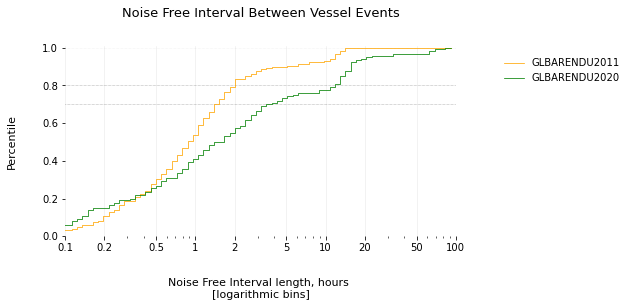

In [17]:
ds = iyore.Dataset(r"E:\Sound Data")

wdir = r"T:\ResMgmt\WAGS\Sound\Experiments & Data\2021 GLBA Vessel Quotas and Operating Requirements plan"

# =========== plot ===================

nfi_refs = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100] # in hours

fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))

for u, s, y, c in [("GLBA", "RENDU", 2011, 'orange'),
                   ("GLBA", "RENDU", 2020, 'green')]:
    
    # to visualize the annotations we: parse + filter + mine + represent...
    base, cumu = VOQR_cumulative_histogram(ds, u, s, y)

    # plot the results
    ax.step(base[:-1], cumu, label=u+s+str(y), 
            lw=0.75, color=c)

ax.set_xscale('log')
ax.set_xlabel("Noise Free Interval length, hours \n[logarithmic bins]", 
              labelpad=25, fontsize=11)
ax.set_xticks(ticks=nfi_refs)
ax.set_xticklabels(labels=nfi_refs)
ax.set_xlim([0.1, 100])

# add visual cues for familiar lengths of time
# (this helps interpret the logarithmic bins)
for t in nfi_refs: 
    ax.axvline(t, lw=0.5, alpha=0.1, color="k", zorder=-2)

ax.set_ylabel("Percentile", labelpad=25, fontsize=11)
ax.set_ylim([0, 1.01])

ax.axhline(1, lw=0.5, ls="dotted", alpha=0.1, color="k", zorder=-2)

ax.axhline(0.8, lw=0.5, ls="dotted", alpha=0.6, color="k", zorder=-2)
ax.axhline(0.7, lw=0.5, ls="dotted", alpha=0.6, color="k", zorder=-2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(bbox_to_anchor=(1.1, 0.9818),
          frameon=False)

ax.set_title("Noise Free Interval Between Vessel Events",
             loc="center", y=1.12, fontsize=13)

plt.savefig(wdir+os.sep+"GLBA_VOQR_VesselNFIs_RENDU_firstDraft.png", dpi=200,
            bbox_inches="tight", facecolor="white")
plt.show()